
# Active Learning 3 – Handling Skewed Data in Spark SQL
## Student Information
### Name: Tanzim Nawaz
### ID: 11834685

This notebook guides you through an end-to-end skew analysis using PySpark:

1. Load a real-world dataset (from Kaggle)
2. Prove skew on a categorical column
3. Measure baseline performance with a skewed self-join
4. Apply salting to mitigate skew
5. Compare and explain results

> Replace placeholders (`dataset_path`, `skew_col`) with your actual data and column name.


In [2]:

from pyspark.sql import SparkSession, functions as F
import time

spark = (
    SparkSession.builder
    .appName("ActiveLearning3_SkewHandling")
    .getOrCreate()
)
print("Spark version:", spark.version)


Spark version: 4.0.0


In [5]:

# Configuration – replace these with your dataset path and skewed column
dataset_path = "data/olist_order_items_dataset.csv"  # <-- UPDATE THIS
skew_col = "seller_id"               # <-- UPDATE THIS

csv_options = {
    "header": "true",
    "inferSchema": "true"
}


In [6]:

df = spark.read.options(**csv_options).csv(dataset_path)
print("Row count:", df.count())
df.show(5, truncate=False)


Row count: 112650
+--------------------------------+-------------+--------------------------------+--------------------------------+-------------------+-----+-------------+
|order_id                        |order_item_id|product_id                      |seller_id                       |shipping_limit_date|price|freight_value|
+--------------------------------+-------------+--------------------------------+--------------------------------+-------------------+-----+-------------+
|00010242fe8c5a6d1ba2dd792cb16214|1            |4244733e06e7ecb4970a6e2683c13e61|48436dade18ac8b2bce089ec2a041202|2017-09-19 09:45:35|58.9 |13.29        |
|00018f77f2f0320c557190d7a144bdd3|1            |e5f2d52b802189ee658865ca93d83a8f|dd7ddc04e1b6c2c614352b383efe2d36|2017-05-03 11:05:13|239.9|19.93        |
|000229ec398224ef6ca0657da4fc703e|1            |c777355d18b72b67abbeef9df44fd0fd|5b51032eddd242adc84c38acab88f23d|2018-01-18 14:48:30|199.0|17.87        |
|00024acbcdf0a6daa1e931b038114c75|1            |7634

+--------------------------------+-----+
|seller_id                       |count|
+--------------------------------+-----+
|6560211a19b47992c3666cc44a7e94c0|2033 |
|4a3ca9315b744ce9f8e9374361493884|1987 |
|1f50f920176fa81dab994f9023523100|1931 |
|cc419e0650a3c5ba77189a1882b7556a|1775 |
|da8622b14eb17ae2831f4ac5b9dab84a|1551 |
|955fee9216a65b617aa5c0531780ce60|1499 |
|1025f0e2d44d7041d6cf58b6550e0bfa|1428 |
|7c67e1448b00f6e969d365cea6b010ab|1364 |
|ea8482cd71df3c1969d7b9473ff13abc|1203 |
|7a67c85e85bb2ce8582c35f2203ad736|1171 |
|4869f7a5dfa277a7dca6462dcf3b52b2|1156 |
|3d871de0142ce09b7081e2b9d1733cb1|1147 |
|8b321bb669392f5163d04c59e235e066|1018 |
|cca3071e3e9bb7d12640c9fbe2301306|830  |
|620c87c171fb2a6dd6e8bb4dec959fc6|798  |
|a1043bafd471dff536d0c462352beb48|770  |
|e9779976487b77c6d4ac45f75ec7afe9|750  |
|f8db351d8c4c4c22c6835c19a46f01b0|724  |
|d2374cbcbb3ca4ab1086534108cc3ab7|631  |
|391fc6631aebcf3004804e51b40bcf1e|613  |
+--------------------------------+-----+
only showing top

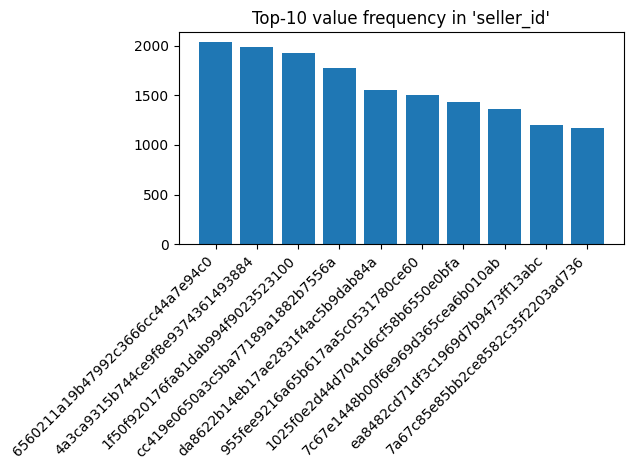

In [7]:

freq_df = df.groupBy(skew_col).count().orderBy(F.col("count").desc())
freq_df.show(20, truncate=False)

# Optional plot for top-10 frequencies
top10 = freq_df.limit(10).toPandas()

import matplotlib.pyplot as plt

plt.figure()
plt.bar(top10[skew_col].astype(str), top10["count"])
plt.title(f"Top-10 value frequency in '{skew_col}'")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [8]:

df1 = df.alias("a")
df2 = df.alias("b")

start = time.time()
baseline_join = df1.join(df2, on=skew_col, how="inner")
baseline_count = baseline_join.count()
baseline_time = time.time() - start

print(f"Baseline join count = {baseline_count}")
print(f"Baseline join time  = {baseline_time:.2f} seconds")


Baseline join count = 48056878
Baseline join time  = 0.75 seconds


In [9]:

salt_factor = 10
df_salt = df.withColumn("salt", (F.rand(seed=42) * salt_factor).cast("int"))

df_left = df_salt.alias("l")
df_right = df_salt.alias("r")

join_condition = (
    (F.col(f"l.{skew_col}") == F.col(f"r.{skew_col}")) &
    (F.col("l.salt") == F.col("r.salt"))
)

start = time.time()
salted_join = df_left.join(df_right, on=join_condition, how="inner")
salted_count = salted_join.count()
salted_time = time.time() - start

print(f"Salted join count = {salted_count}")
print(f"Salted join time  = {salted_time:.2f} seconds")


Salted join count = 4908844
Salted join time  = 0.40 seconds



## Compare Results

| Join Type | Count         | Time (s)     |
|-----------|---------------|--------------|
| Baseline  | 48056878  | 0.75 |
| Salted    | 4908844  | 0.40  |

### Discussion
- Did salting reduce join time?

Yes salting reduced the join time from 0.75 seconds to 0.4 seconds

- Were there any surprises in the results?

The large reduction in join count was a big surprise. But it does make sense when considering how inner join works and now that we have introduced salting. Something notable is that that the final row count decreased by around 90% but the time taken has decreased a little less than 50%. So their relation is not linear and this will impact the answer to the next question.

- How might partitioning or data volume affect your strategy?

From the results I have gotten from this experiment, my understanding is that salting will be more effective the larger the dataset is. We might be able to skip salting entirely if the dataset is not too large. This is because there are other calculation overhead which will make salting inefficient fpr smaller dataset.

If the data is well partitioned, then the skew may only be present in only certain partitions. In such scenario, we can only salt those affected partitions.